In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
rng = np.random.RandomState(20180201)
DEFAULT_SEED = 20180201
DATA_DIR = "../data/"
DATA_FILE = "creditcard.csv"

In [44]:
data = pd.read_csv(DATA_DIR+DATA_FILE)
stats = pd.DataFrame({'mean':data.mean(), 'std':data.std(), 'skew':data.skew()})

# normalize the data
data['Amount'] = data['Amount'].apply(lambda x: np.log(x+1e-6))
data.loc[:,'V1':'Amount'] = data.loc[:,'V1':'Amount'].apply(lambda x: (x-x.mean())/x.std())
#data.loc[:,'V1':'V28'] = data.loc[:,'V1':'V28'].apply(lambda x: (x-x.min())/(x.std(x.max()-x.min())))

ValueError: ("No axis named 58.86243962254021 for object type <class 'pandas.core.series.Series'>", 'occurred at index V1')

In [36]:
def plot(data, key, title):
    pos_data = data[data["Class"]==1]
    neg_data = data[data["Class"]==0]
    fig = plt.figure(figsize=(12,2))
    plt.hist(pos_data[key], histtype="step", density=True, bins=50, label="pos")
    plt.hist(neg_data[key], histtype="step", density=True, bins=50, label="neg")
    plt.xlim(-3,)
    plt.title(title)
    plt.ylabel("Probability Density")
    plt.legend()
    plt.draw()
    fig.savefig(key+".pdf")

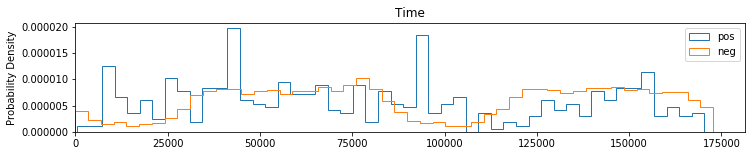

In [37]:
plot(data, 'Time')

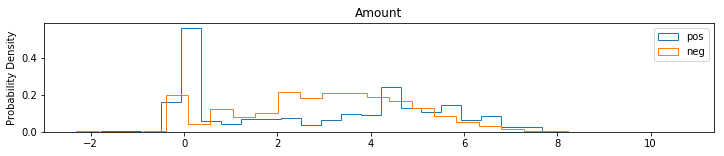

In [40]:
plot(data, 'Amount')

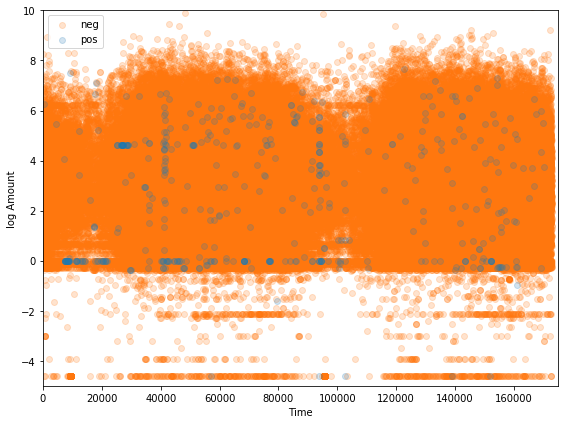

In [42]:
pos_data = data[data["Class"]==1]
neg_data = data[data["Class"]==0]
fig = plt.figure(figsize=(8,6))
plt.scatter(neg_data['Time'], neg_data['Amount'], label='neg', alpha=0.2, color='#ff770e')
plt.scatter(pos_data['Time'], pos_data['Amount'], label='pos', alpha=0.8, color='#1f77b4')
plt.xlabel('Time')
plt.ylabel('log Amount')
plt.xlim(0, 175000)
plt.ylim(-5, 10)
plt.legend()
plt.draw()
plt.tight_layout()
plt.savefig("TimeVsAmount.pdf")

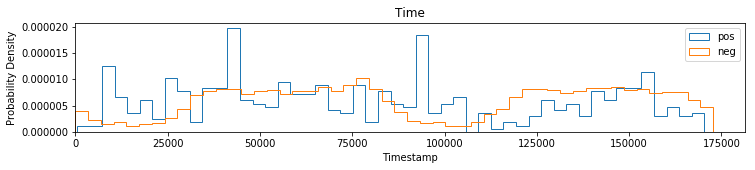

In [4]:
# plot the histograms of data in each axises
plot=True
if plot:
    pos_data = data[data["Class"]==1]
    neg_data = data[data["Class"]==0]
    for key in data.keys()[1:-1]: # for all principle components
        fig = plt.figure(figsize=(12,2))
        plt.hist(pos_data[key], histtype="step", density=True, bins=50, label="pos")
        plt.hist(neg_data[key], histtype="step", density=True, bins=50, label="neg")
        plt.xlim(-3,)
        plt.title(key)
        plt.xlabel("Normalized Value")
        plt.ylabel("Probability Density")
        plt.legend()
        plt.draw()
        fig.savefig(key+"_Scaled.pdf")

In [5]:
def split_DataFrame(data, label, frac, rng=None):
    '''
    Split the data into two part, and remain the same event propotion in the results.
    
    Input:
        data (pd.DataFrame): the Input data
        label (string): the event class label
        frac (float): the propotion of the first part
        rng (np.RandomState): NumPy random state

    Return:
        tuple of two subparst of the data
    '''
    if rng is None:
        rng = np.random.RandomState(DEFAULT_SEED)
    subdf1 = pd.DataFrame()
    subdf2 = pd.DataFrame()
    count = data[label].value_counts()
    for val in count.keys():
        df = data[data[label]==val]
        mask = rng.rand(len(df)) < frac
        subdf1 = pd.concat([df[mask]] + [subdf1])
        subdf2 = pd.concat([df[~mask]] + [subdf2])
    return (subdf1, subdf2)

def oversample(df_input, label, rng=None):
    '''
    Simply duplicate the data with minority label to let all category have the close amount
    
    Input:
        df_input (pd.DataFrame): the Input data
        label (string): the event class label
        rng (np.RandomState): NumPy random state
        
    Return:
        oversampled DataFrame
    '''
    if rng is None:
        rng = np.random.RandomState(DEFAULT_SEED)
    count = df_input[label].value_counts()
    repeat = np.array(np.ceil(count.max()/count), dtype=np.int)
    res = pd.DataFrame()
    for val, nrep in zip(count.keys(), repeat):
        df = df_input[df_input[label]==val]
        res = pd.concat([res] + [df]*nrep)
    return res.sample(frac=1, random_state=rng).reset_index(drop=True)

def smote_oversample(df, lebal, val, n_sample, k_neighbor, n_gen, rng=None):
    
    if rng is None:
        rng = np.random.RandomState(DEFAULT_SEED)
    df_minority = df[df[lebal]==val]
    assert n_sample <= df_minority.shape[0]
    assert k_neighbor < df_minority.shape[0]
    df_minority = np.array(df_minority)
    for i in range(n_sample):
        xi = df_minority[i]
        resdf = np.delete(df_minority, i, 0)
        dist = []
        for xii in resdf:
            idist = np.linalg.norm(xi-xii)
            dist.append(idist)
        dist = np.array(dist)
        ridx = rng.randint(k_neighbor,size=n_gen)
        rshift = rng.rand(n_gen,1)
        gen = xi + (resdf[dist.argsort()[:k_neighbor]][ridx]-xi) * rshift
        gen_df = pd.DataFrame(gen, columns=df.columns)
        df = df.append(gen_df)
    return df.sample(frac=1, random_state=rng).reset_index(drop=True)

In [9]:
# train : test : valid = 0.6 : 0.2 : 0.2 
train_df, evalu = split_DataFrame(data, label='Class', frac=0.6, rng=rng)
#train_df = oversample(train_df, label='Class', rng=rng)
train_df = smote_oversample(train_df, 'Class', 1, 280, 140, 500, rng=rng)
test_df, valid_df = split_DataFrame(evalu, label='Class', frac=0.5, rng=rng)

train = train_df.as_matrix()
test = test_df.as_matrix()
valid = valid_df.as_matrix()

np.savez_compressed(DATA_DIR+'ccdataset.npz', train=train, test=test, valid=valid)

In [10]:
train_df['Class'].value_counts()

0.0    170690
1.0    140287
Name: Class, dtype: int64

In [43]:
def factor_scatter_matrix(df, factor, palette=None):
    # modiflied from https://stackoverflow.com/questions/22943894/class-labels-in-pandas-scattermatrix
    '''Create a scatter matrix of the variables in df, with differently colored
    points depending on the value of df[factor].
    inputs:
        df: pandas.DataFrame containing the columns to be plotted, as well 
            as factor.
        factor: string or pandas.Series. The column indicating which group 
            each row belongs to.
        palette: A list of hex codes, at least as long as the number of groups.
            If omitted, a predefined palette will be used, but it only includes
            9 groups.
    '''
    import matplotlib.colors
    import numpy as np
    from pandas.plotting import scatter_matrix
    from scipy.stats import gaussian_kde

    if isinstance(factor, str):
        factor_name = factor #save off the name
        factor = df[factor] #extract column
        df = df.drop(factor_name,axis=1) # remove from df, so it 
        # doesn't get a row and col in the plot.

    classes = list(set(factor))

    if palette is None:
        palette = ['#e41a1c', '#377eb8', '#4eae4b', 
                   '#994fa1', '#ff8101', '#fdfc33', 
                   '#a8572c', '#f482be', '#999999']

    color_map = dict(zip(classes,palette))

    if len(classes) > len(palette):
        raise ValueError('''Too many groups for the number of colors provided.
We only have {} colors in the palette, but you have {}
groups.'''.format(len(palette), len(classes)))

    colors = factor.apply(lambda group: color_map[group])
    axarr = scatter_matrix(df,figsize=(24,24),marker='o',c=colors,diagonal=None,alpha=0.2)


    for rc in range(len(df.columns)):
        for group in classes:
            y = df[factor == group].iloc[rc].values
            gkde = gaussian_kde(y)
            ind = np.linspace(y.min(), y.max(), 1000)
            axarr[rc][rc].plot(ind, gkde.evaluate(ind),c=color_map[group])

    return axarr, color_map

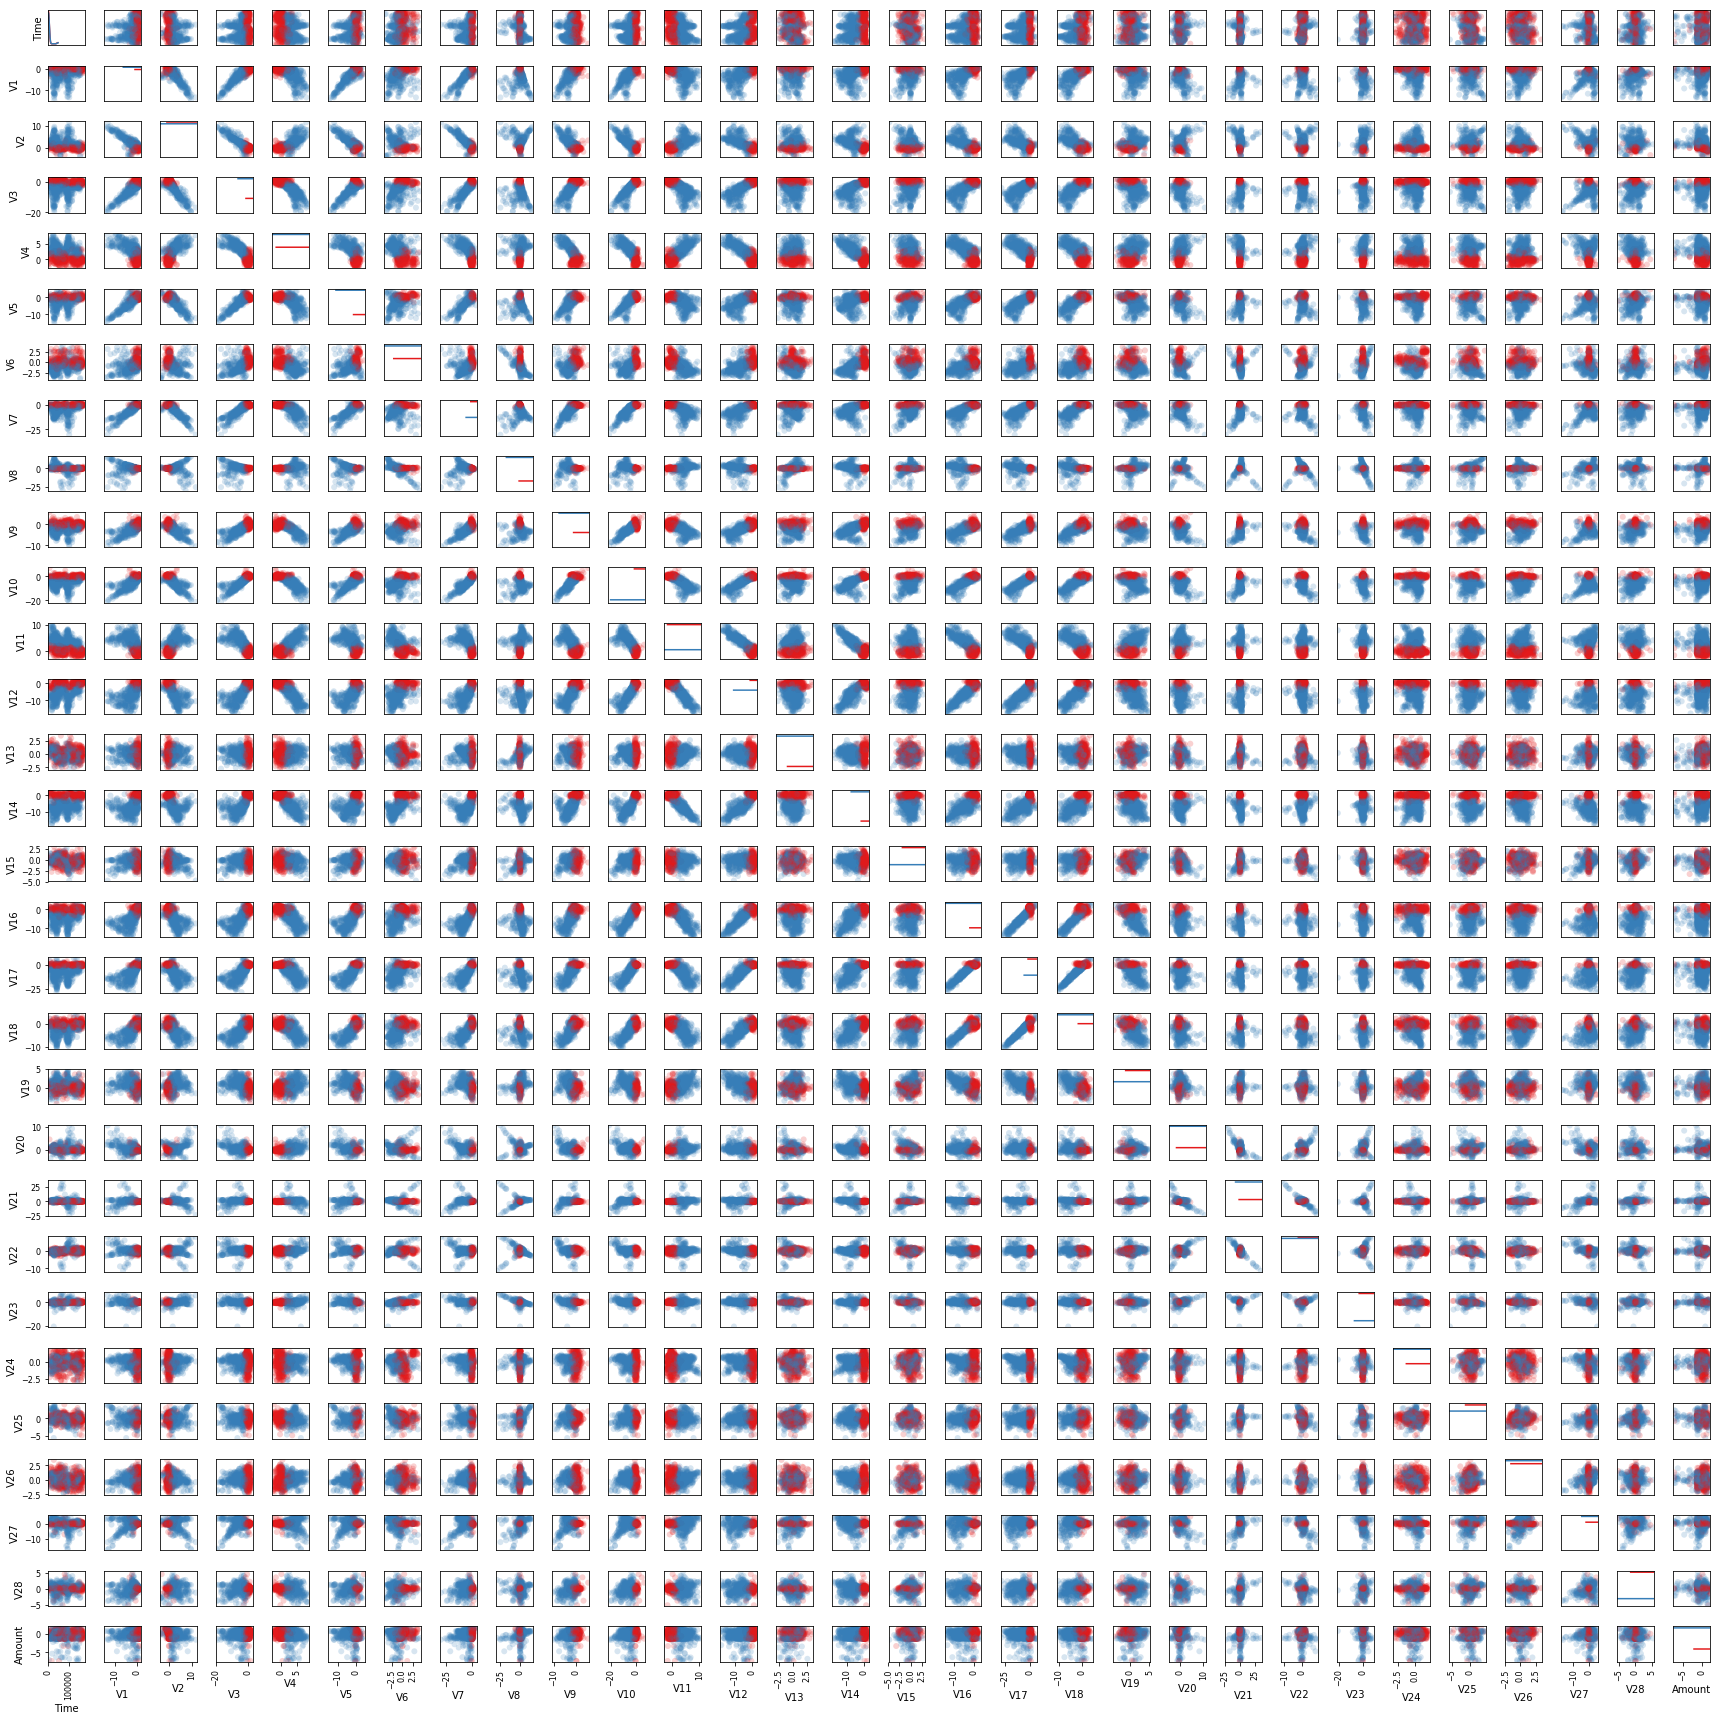

In [19]:
axarr, color_map = factor_scatter_matrix(train_df.head(1000),'Class')
plt.tight_layout()
plt.savefig('scatter_matrix.pdf')